In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import pickle
import matplotlib.pyplot as plt


# components analysis

In [23]:
def visualize_subgraphs(original_graph, selected_graph, title="Selected Subgraphs"):
    """
    Visualizes the original graph and the selected subgraphs side by side.
    
    Parameters:
        original_graph (networkx.Graph): The full original graph.
        selected_graph (networkx.Graph): The graph containing the selected subgraphs.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(12, 6))

    # Original graph
    plt.subplot(1, 2, 1)
    nx.draw(original_graph, node_size=20, edge_color='gray', with_labels=False)
    plt.title("Original Graph")

    # Selected subgraphs
    plt.subplot(1, 2, 2)
    nx.draw(selected_graph, node_size=20, edge_color='blue', with_labels=False)
    plt.title(title)

    plt.show()

def analyze_component_sizes(graphs):
    """
    Analyzes the component size distributions for a list of graphs.
    
    Parameters:
        graphs (list of networkx.Graph): List of graphs to analyze.
    
    Returns:
        list: List of component size distributions for each graph.
    """
    all_sizes = []
    for graph in graphs:
        component_sizes = [len(c) for c in nx.connected_components(graph)]
        all_sizes.extend(component_sizes)
    return np.array(all_sizes)

def get_percentile_based_subgraphs(graph, lower_percentile=90, upper_percentile=99):
    """
    Extracts subgraphs based on component sizes within specified percentiles.
    """
    
    # Get all components and their sizes
    components = list(nx.connected_components(graph))
    component_sizes = np.array([len(c) for c in components])
    
    # Calculate size thresholds
    min_size = np.percentile(component_sizes, lower_percentile)
    max_size = np.percentile(component_sizes, upper_percentile)
    
    # Filter components by size range
    filtered_components = [
        component for component in components
        if min_size <= len(component) <= max_size
    ]
    
    # Combine selected subgraphs into a single graph
    combined_graph = nx.compose_all([graph.subgraph(component).copy() for component in filtered_components])
    nodes_rate = combined_graph.number_of_nodes() / graph.number_of_nodes()
    return combined_graph, len(filtered_components), nodes_rate

def get_top_k_components(graph, k=1):
    """
    Extracts the k largest connected components from a NetworkX graph.
    """
    # Get all connected components sorted by size (largest first)
    components = sorted(nx.connected_components(graph), key=len, reverse=True)
    
    # Get subgraphs for the top k components
    top_k_subgraphs = [graph.subgraph(component).copy() for component in components[:k]]

    component_sizes = [len(c) for c in nx.connected_components(graph)]
    print("Component size distribution:", np.percentile(component_sizes, [10, 25, 50, 75, 90, 95, 99]))
    # Combine the subgraphs into a single graph
    combined_graph = nx.compose_all(top_k_subgraphs)

    nodes_rate = combined_graph.number_of_nodes() / graph.number_of_nodes()
    return combined_graph, len(components), nodes_rate

def load_custom_graphs(directory, data_type='ovarian', k=3):
    graph_list = []
    components_list = []
    nodes_rate_list = []
    i = 0
    # controls the patients type used in experiment
    invalid_files = ["fp"]
    for filename in os.listdir(directory):
        # maybe check files ends with 'pkl' if neccecary in future
        if all(invalid not in filename for invalid in invalid_files):
            # print(f"\tWorking on file: {filename}")
            file_path = os.path.join(directory, filename)
            with open(file_path, 'rb') as f:
                G = pickle.load(f)  # Load NetworkX graph from pkl file
            # G, num_comp, nodes_rate = get_top_k_components(G, k)
            selected_graph, num_comp, nodes_rate = get_percentile_based_subgraphs(G, lower_percentile=1, upper_percentile=89)
            components_list.append(num_comp)
            nodes_rate_list.append(nodes_rate) 
            graph_list.append(selected_graph)
            # if i < 3:
            #     visualize_subgraphs(G, selected_graph, title="90th–99th Percentile Subgraphs") 
            # i += 1
    print(f"avg number of components in selected_graph: {np.mean(components_list)}")
    print(f"avg ratio of nodes (nodes in subgraphs / nodes in original graph): {np.mean(nodes_rate)}")
    # Assuming `graph_list` is your list of graphs
    all_component_sizes = analyze_component_sizes(graph_list)

    # # Visualize size distribution
    # plt.hist(all_component_sizes, bins=50, log=True)
    # plt.title("Component Size Distribution")
    # plt.xlabel("Component Size")
    # plt.ylabel("Frequency")
    # plt.show()

In [5]:
DATASET_DIR = '/home/dsi/orrbavly/GNN_project/data/embedding_graphs_90th_perc_new' 
DATA_TYPE = 'ovarian'
K=3

In [24]:
load_custom_graphs(DATASET_DIR, data_type=DATA_TYPE, k=K)


avg number of components in selected_graph: 5388.820143884892
avg ratio of nodes (nodes in subgraphs / nodes in original graph): 0.47331833980781024


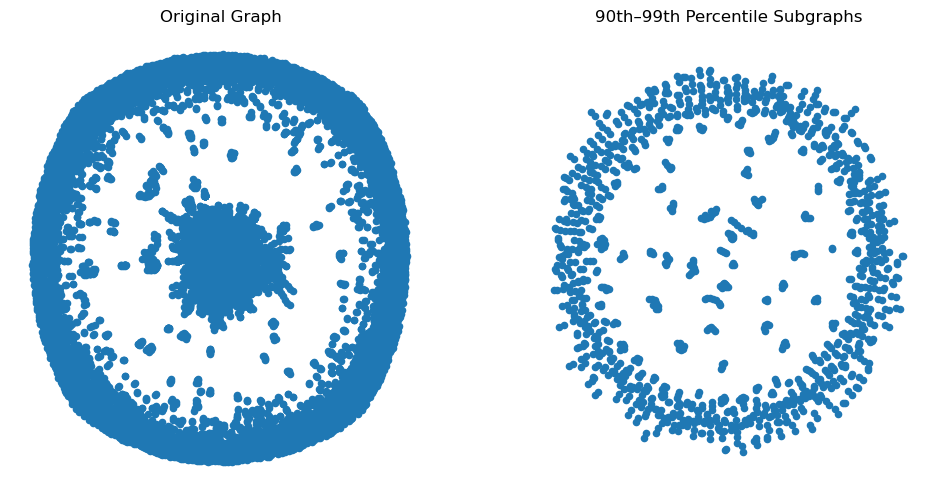

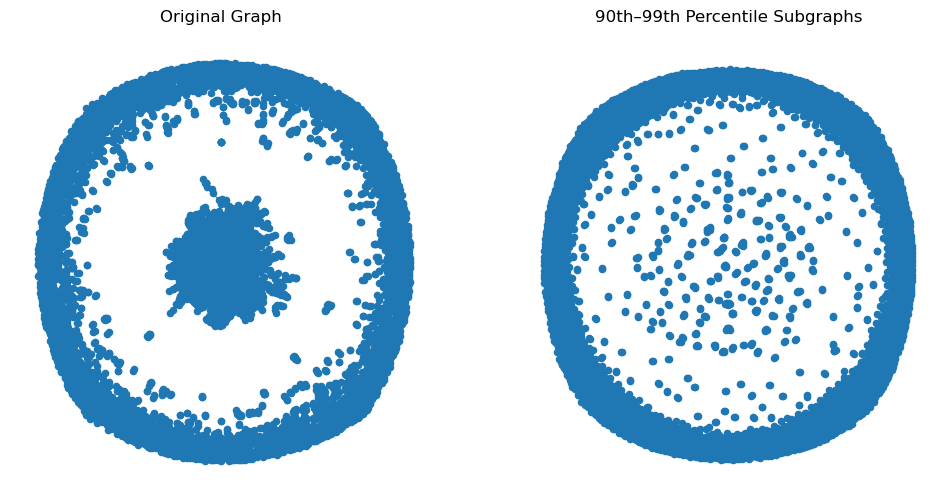

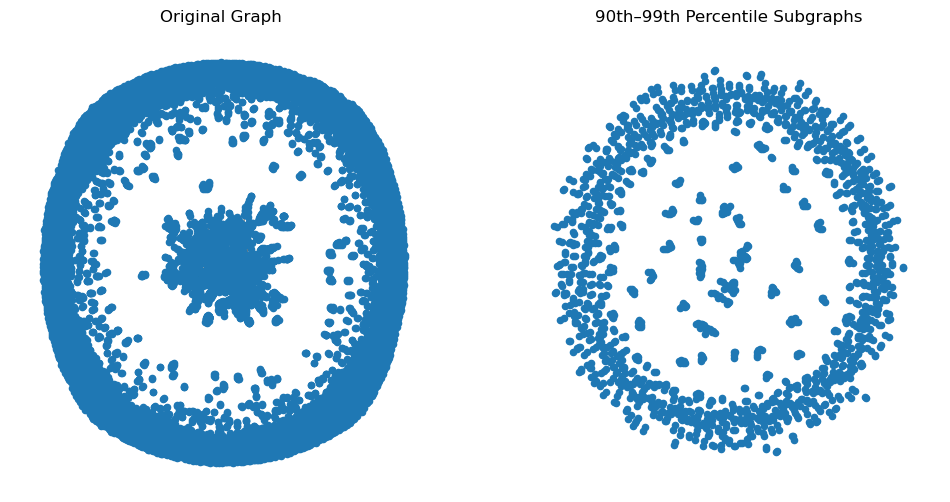

avg number of components: 5903.949640287769
avg ratio of nodes (nodes in subgraphs / nodes in original graph): 0.538267566278198


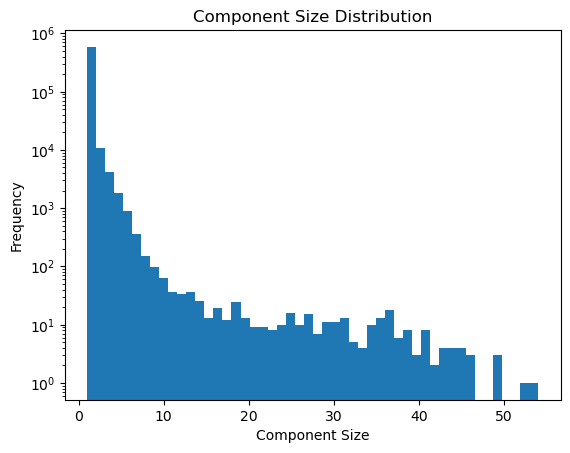

In [20]:
load_custom_graphs(DATASET_DIR, data_type=DATA_TYPE, k=K)


# Stats_csv EDA

In [23]:
stats_outliners = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/colon_samples_stats_outlines_xgboost.csv")
stats_regular = pd.read_csv("/home/dsi/orrbavly/GNN_project/outputs/colon_samples_stats_rf.csv")
metadata_df = pd.read_csv("/home/dsi/orrbavly/GNN_project/data/colon_meta.csv")

<function matplotlib.pyplot.show(close=None, block=None)>

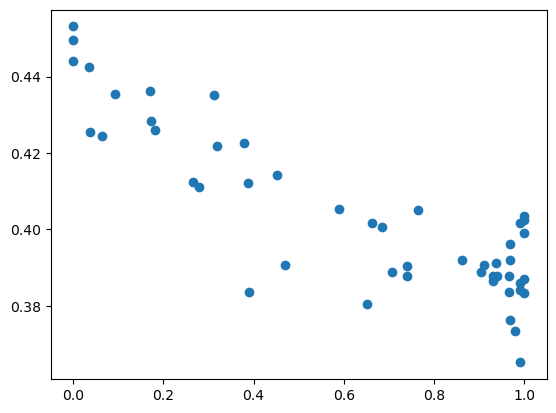

In [24]:
plt.scatter(stats_outliners['appearance_rate'], stats_outliners['average_f1_score'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

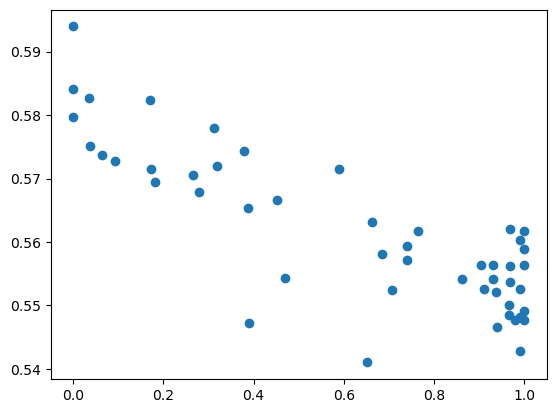

In [25]:
plt.scatter(stats_outliners['appearance_rate'], stats_outliners['average_balanced_accuracy'])
plt.show

In [26]:
# Extract the key (e.g., pool{number}_S{number}) from both DataFrames
stats_outliners['merge_key'] = stats_outliners['sample_name'].str.extract(r'(pool\d+_S\d+)')
metadata_df['merge_key'] = metadata_df['filename'].str.extract(r'(pool\d+_S\d+)')

stats_outliners = pd.merge(
    stats_outliners, 
    metadata_df[['merge_key', 'T', 'N', 'M']], 
    on='merge_key', 
    how='inner'
)

# Drop the redundant 'merge_key' column after merging if no longer needed
stats_outliners = stats_outliners.drop(columns=['merge_key'])
stats_outliners['N'] = stats_outliners['N'].replace({'1a':'1', '1b': '1'})


In [27]:
stats_outliners['T'] = stats_outliners['T'].replace({'T4a':'T4'})

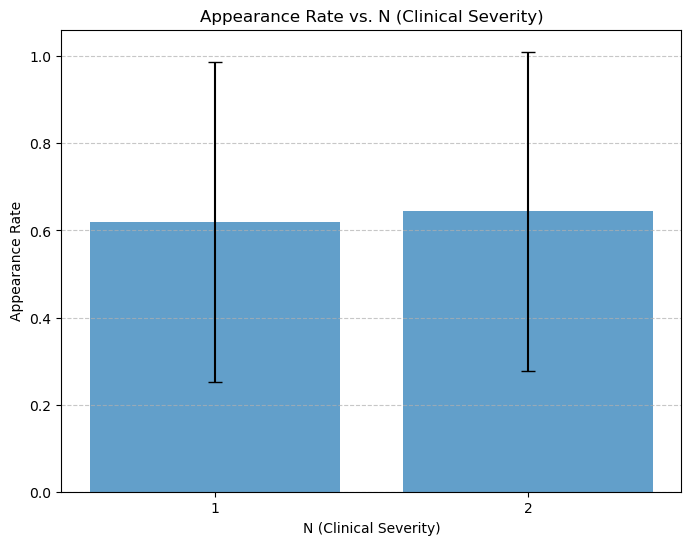

In [28]:
# Group appearance_rate by N and calculate mean and standard deviation
grouped_data = stats_outliners.groupby('N')['appearance_rate'].agg(['mean', 'std']).reset_index()

# Bar plot for appearance_rate by N
plt.figure(figsize=(8, 6))
plt.bar(grouped_data['N'], grouped_data['mean'], yerr=grouped_data['std'], capsize=5, alpha=0.7)
plt.title('Appearance Rate vs. N (Clinical Severity)')
plt.xlabel('N (Clinical Severity)')
plt.ylabel('Appearance Rate')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

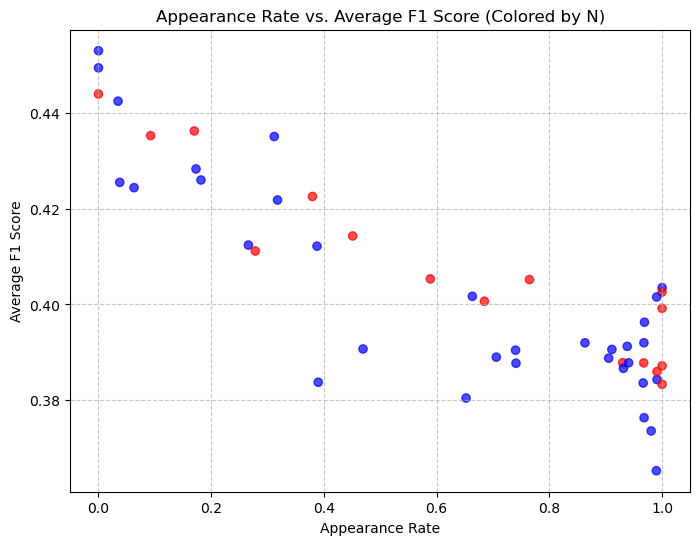

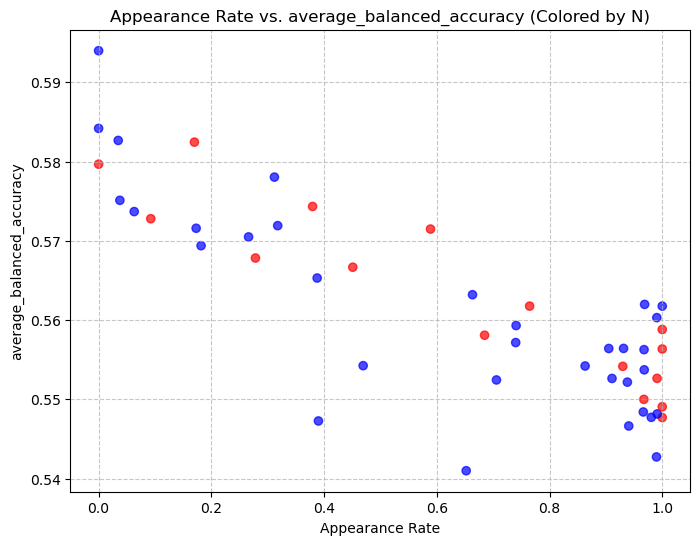

In [29]:
# Define colors based on N values
colors = stats_outliners['N'].map({'1': 'blue', '2': 'red'})

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    stats_outliners['appearance_rate'],
    stats_outliners['average_f1_score'],
    c=colors,
    alpha=0.7 ## data transperasy
)

plt.title('Appearance Rate vs. Average F1 Score (Colored by N)')
plt.xlabel('Appearance Rate')
plt.ylabel('Average F1 Score')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    stats_outliners['appearance_rate'],
    stats_outliners['average_balanced_accuracy'],
    c=colors,
    alpha=0.7 ## data transperasy
)

plt.title('Appearance Rate vs. average_balanced_accuracy (Colored by N)')
plt.xlabel('Appearance Rate')
plt.ylabel('average_balanced_accuracy')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

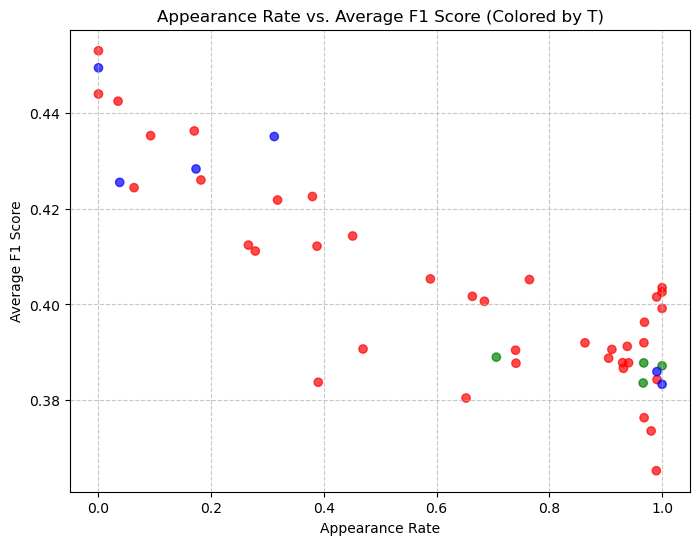

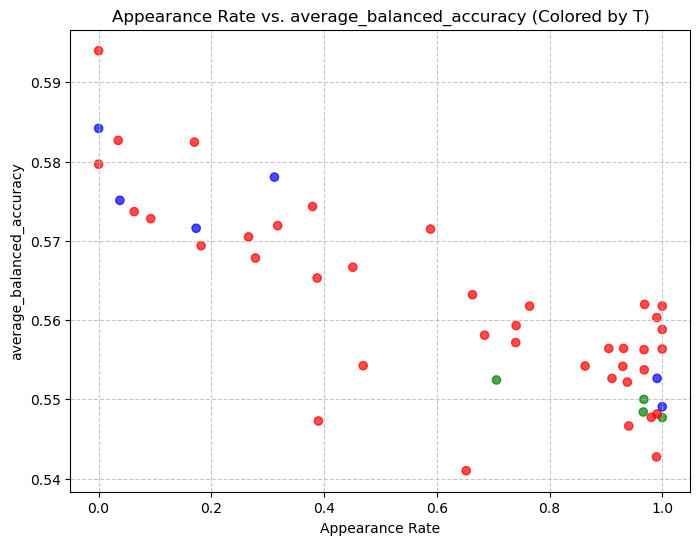

In [30]:
# Define colors based on N values
colors = stats_outliners['T'].map({'T2': 'blue', 'T3': 'red', 'T4': 'green'})

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    stats_outliners['appearance_rate'],
    stats_outliners['average_f1_score'],
    c=colors,
    alpha=0.7 ## data transperasy
)

plt.title('Appearance Rate vs. Average F1 Score (Colored by T)')
plt.xlabel('Appearance Rate')
plt.ylabel('Average F1 Score')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    stats_outliners['appearance_rate'],
    stats_outliners['average_balanced_accuracy'],
    c=colors,
    alpha=0.7 ## data transperasy
)

plt.title('Appearance Rate vs. average_balanced_accuracy (Colored by T)')
plt.xlabel('Appearance Rate')
plt.ylabel('average_balanced_accuracy')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

In [31]:
n_counts = stats_outliners['N'].value_counts()
print(f"Number of samples for each N value: {n_counts}")

print(f"Number of samples for each T value: {stats_outliners['T'].value_counts()}")
print(f"Number of samples for each M value: {stats_outliners['M'].value_counts()}")

Number of samples for each N value: N
1    33
2    16
Name: count, dtype: int64
Number of samples for each T value: T
T3    39
T2     6
T4     4
Name: count, dtype: int64
Number of samples for each M value: M
0      20
Mx      9
X       4
M1      4
M1a     1
M1c     1
1       1
Name: count, dtype: int64


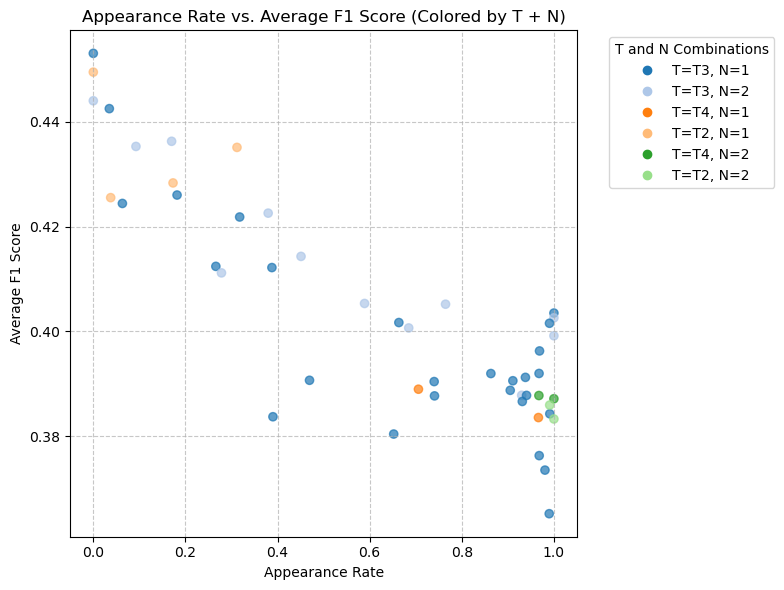

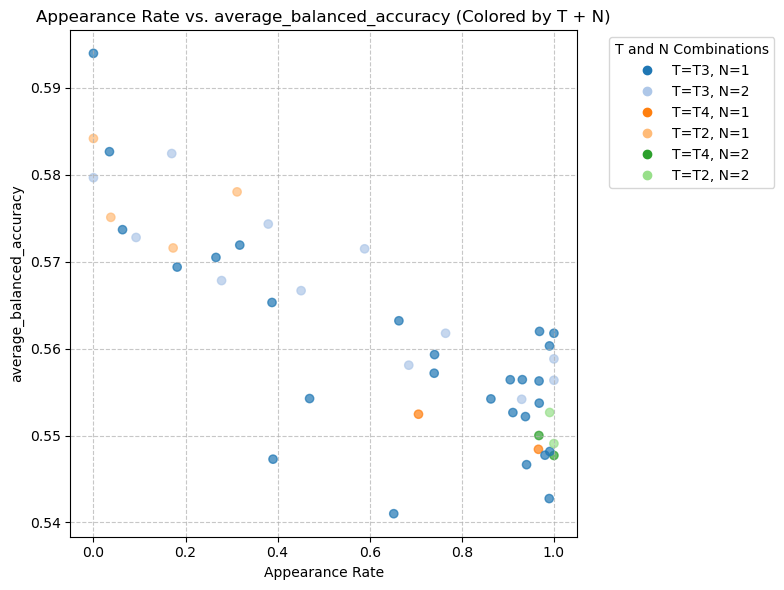

In [44]:
# Generate a unique color for each combination of T and N
unique_combinations = stats_outliners[['T', 'N']].dropna().drop_duplicates()
color_map = {tuple(row): color for row, color in zip(unique_combinations.values, plt.cm.tab20.colors)}

# Map each combination to its color
colors = stats_outliners.apply(lambda row: color_map.get((row['T'], row['N']), 'gray'), axis=1)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    stats_outliners['appearance_rate'],
    stats_outliners['average_f1_score'],
    c=colors,
    alpha=0.7  # Transparency for data points
)

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', label=f'T={key[0]}, N={key[1]}') 
           for key, color in color_map.items()]
plt.legend(handles=handles, title="T and N Combinations", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set plot titles and labels
plt.title('Appearance Rate vs. Average F1 Score (Colored by T + N)')
plt.xlabel('Appearance Rate')
plt.ylabel('Average F1 Score')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout for legend
plt.show()

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    stats_outliners['appearance_rate'],
    stats_outliners['average_balanced_accuracy'],
    c=colors,
    alpha=0.7  # Transparency for data points
)

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', label=f'T={key[0]}, N={key[1]}') 
           for key, color in color_map.items()]
plt.legend(handles=handles, title="T and N Combinations", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set plot titles and labels
plt.title('Appearance Rate vs. average_balanced_accuracy (Colored by T + N)')
plt.xlabel('Appearance Rate')
plt.ylabel('average_balanced_accuracy')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout for legend
plt.show()

# Unsupervised Clustering

In [33]:
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [34]:
colon_path = "/home/dsi/orrbavly/GNN_project/embeddings/colon_percentiles/TRB/percentiles_results_cos_3_all.json"

In [35]:
def load_results(file_path, data_type):
    # load json file
    with open(file_path, 'r') as f:
        all_results = json.load(f)
    # create labels dictionary
    labels_dict = {}
    for sample_name, percentile_dict in all_results.items():
        if data_type == 'ovarian':
            if sample_name.endswith("_H"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_OC"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
        elif data_type == 'colon':
            if sample_name.endswith("_low"):
                labels_dict[sample_name] = 0
            elif sample_name.endswith("_high"):
                labels_dict[sample_name] = 1
            else:
                raise Exception("Error - invalid sample type")
    return all_results, labels_dict

def load_json_and_extract_features_as_lists(json_path, stack=False):
    """Load JSON file, extract statistical features, and return structured lists of lists for each group."""
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    group_0 = []
    group_1 = []
    
    for sample_name, percentiles_dict in data.items():
        # Convert the JSON data structure to a list of lists for each sample
        sample_data = [[int(k)] + v for k, v in percentiles_dict.items()]  # Convert each k-value dictionary entry to a list

        # Extract statistical features for this sample
        features_df = extract_statistical_features_from_percentiles([sample_data], list(percentiles_dict.keys()), stack)

        # Initialize lists for each feature across all k values
        iqr_values = ['iqr']
        lower_tail_range_values = ['lower_tail_range']
        upper_tail_range_values = ['upper_tail_range']
        lower_tail_ratio_values = ['lower_tail_ratio']
        upper_tail_ratio_values = ['upper_tail_ratio']
        percentile_90_10_diff_values = ['percentile_90_10_diff']
        percentile_95_5_diff_values = ['percentile_95_5_diff']
        
        # Populate each feature list with values from all k's in the original JSON order
        for col in features_df.columns[1:]:  # Skip 'Sample' column
            if 'iqr' in col:
                iqr_values.append(features_df[col].iloc[0])
            elif 'lower_tail_range' in col:
                lower_tail_range_values.append(features_df[col].iloc[0])
            elif 'upper_tail_range' in col:
                upper_tail_range_values.append(features_df[col].iloc[0])
            elif 'lower_tail_ratio' in col:
                lower_tail_ratio_values.append(features_df[col].iloc[0])
            elif 'upper_tail_ratio' in col:
                upper_tail_ratio_values.append(features_df[col].iloc[0])
            elif 'percentile_90_10_diff' in col:
                percentile_90_10_diff_values.append(features_df[col].iloc[0])
            elif 'percentile_95_5_diff' in col:
                percentile_95_5_diff_values.append(features_df[col].iloc[0])

        # Combine all feature lists for this sample
        sample_features = {
            "sample_name": sample_name,
            "features": {
                "iqr": iqr_values,
                "lower_tail_range": lower_tail_range_values,
                "upper_tail_range": upper_tail_range_values,
                "lower_tail_ratio": lower_tail_ratio_values,
                "upper_tail_ratio": upper_tail_ratio_values,
                "percentile_90_10_diff": percentile_90_10_diff_values,
                "percentile_95_5_diff": percentile_95_5_diff_values,
            }
        }

        # Append to the appropriate group based on sample_name
        if 'H' in sample_name or 'low' in sample_name:
            group_0.append(sample_features)
        elif 'OC' in sample_name or 'high' in sample_name:
            group_1.append(sample_features)
    
    return group_0, group_1

def extract_statistical_features_from_percentiles(samples, k_labels, stack=False):
    feature_list = []

    for sample_idx, sample in enumerate(samples):
        sample_features = {}
        sample_features['Sample'] = sample_idx
        
        for k_index, k_label in enumerate(k_labels):
            # Extract the provided percentiles for this k value
            percentiles = sample[k_index][1:]  # Exclude the k_value itself, just get percentiles
            
            if stack:
                perc = []
                half_size = len(percentiles) // 2
                for i in range (half_size):
                    value = 0.7 * percentiles[i] + 0.3 * percentiles[half_size + i]
                    perc.append(value)
                p5, p15, p25, p35, p50, p70, p80, p90, p95 = perc
            else:
                # Map the percentiles to variables for clarity
                p5, p15, p25, p35, p50, p70, p80, p90, p95 = percentiles

            # Calculate key features
            iqr = p70 - p25  # Interquartile Range (estimated as 75-25 range)
            lower_tail_range = p25 - p5  # Approximate lower tail range as 25-5
            upper_tail_range = p95 - p70  # Approximate upper tail range as 95-75
            
            # Calculate ratios
            lower_tail_ratio = lower_tail_range / iqr if iqr != 0 else 0
            upper_tail_ratio = upper_tail_range / iqr if iqr != 0 else 0
            
            # Additional quantile differences
            percentile_90_10_diff = p90 - p15  # 90th - 10th percentile difference
            percentile_95_5_diff = p95 - p5    # 95th - 5th percentile difference

            # Store features in the dictionary with keys indicating k value and metric
            sample_features[f'k={k_label}_iqr'] = iqr
            sample_features[f'k={k_label}_lower_tail_range'] = lower_tail_range
            sample_features[f'k={k_label}_upper_tail_range'] = upper_tail_range
            sample_features[f'k={k_label}_lower_tail_ratio'] = lower_tail_ratio
            sample_features[f'k={k_label}_upper_tail_ratio'] = upper_tail_ratio
            sample_features[f'k={k_label}_percentile_90_10_diff'] = percentile_90_10_diff
            sample_features[f'k={k_label}_percentile_95_5_diff'] = percentile_95_5_diff
        
        # Add this sample's features to the list
        feature_list.append(sample_features)
    
    # Convert the list of feature dictionaries to a DataFrame
    feature_df = pd.DataFrame(feature_list)
    return feature_df


def prepare_data_from_groups(group_0, group_1, metadata_df, average_vectors=False, vector_indices=None):
    data = []
    labels = []
    sample_names = []  # To store sample names

    # Define the maximum length for padding
    max_length = 0

    # Combine groups and assign labels
    combined_data = group_0 + group_1
    combined_labels = [0] * len(group_0) + [1] * len(group_1)


    # Find the maximum length needed for padding based on selected indices
    if not average_vectors:
        if vector_indices is not None:
            max_length = max(
                len(np.concatenate([patient_features["features"][i][1:] for i in vector_indices if i < len(patient_features["features"])]))
                for patient_features in combined_data
            )
        else:
            max_length = max(
                len(np.concatenate([feature[1:] for feature in patient_features["features"].values()]))
                for patient_features in combined_data
            )

    for patient_features, label in zip(combined_data, combined_labels):
        # Extract sample name and feature values
        sample_name = patient_features["sample_name"]
        vectors = [feature[1:] for feature in patient_features["features"].values()]

        if average_vectors:
            # Calculate the mean across all k values for each feature
            avg_vector = np.mean(np.array(vectors), axis=0)
            data.append(avg_vector)
        else:
            if vector_indices is not None:
                selected_vectors = [vectors[i] for i in vector_indices if i < len(vectors)]
                flattened_features = np.concatenate(selected_vectors)
            else:
                flattened_features = np.concatenate(vectors)

            # Pad the concatenated features to match the max length
            padded_features = np.pad(flattened_features, (0, max_length - len(flattened_features)), 'constant')
            data.append(padded_features)

        labels.append(label)
        sample_names.append(sample_name)  # Retain original sample name

    # Convert data and labels to arrays
    data = np.array(data)
    labels = np.array(labels)
    sample_names = np.array(sample_names)

    return run_kmeans(data, labels, sample_names, metadata_df)

In [36]:
def run_kmeans(data, labels, sample_names, metadata_df):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    n_clusters = 2
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(data_scaled)
    # 3. Map clusters back to sample names for analysis
    # 3. Align metadata with clusters using merge keys
    metadata_df['merge_key'] = metadata_df['filename'].str.extract(r'(pool\d+_S\d+)')
    sample_names_df = pd.DataFrame({
        'Sample Name': sample_names,
        'merge_key': pd.Series(sample_names).str.extract(r'(pool\d+_S\d+)')[0],
        'Cluster': clusters,
        'Label': labels
    })
    merged_data = pd.merge(
        sample_names_df,
        metadata_df[['merge_key', 'T', 'N', 'M']],
        on='merge_key',
        how='inner'
    )
    # 4. Dimensionality reduction for visualization
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)

    # 5. Visualization of clusters
    plt.figure(figsize=(8, 6))
    for cluster_id in range(n_clusters):
        indices = clusters == cluster_id
        plt.scatter(
            data_pca[indices, 0],
            data_pca[indices, 1],
            label=f'Cluster {cluster_id}',
            alpha=0.7
        )

    plt.title('K-Means Clustering Visualization (2D PCA)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid()
    plt.show()

  # 6. Analyze metadata distribution across clusters
    cluster_metadata_summary = merged_data.groupby('Cluster')[['T', 'N', 'M']].apply(lambda x: x.value_counts())
    print("Metadata Distribution Across Clusters:")
    print(cluster_metadata_summary)
    
    # 7. Calculate Silhouette Score
    from sklearn.metrics import silhouette_score
    silhouette_avg = silhouette_score(data_scaled, clusters)
    print(f"Silhouette Score: {silhouette_avg:.2f}")

    return merged_data

In [37]:
metadata_df = pd.read_csv("/home/dsi/orrbavly/GNN_project/data/colon_meta.csv")

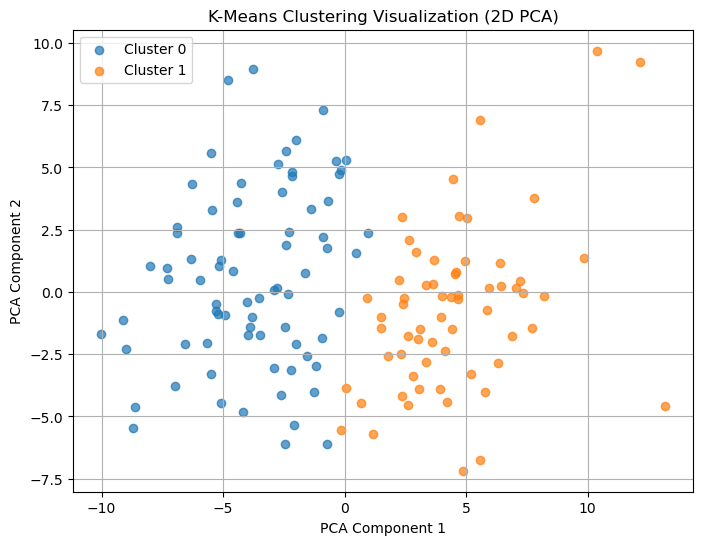

Metadata Distribution Across Clusters:
Cluster  T    N   M  
0        T3   0   0      13
         T2   0   0       8
                  Mx      7
         T3   0   Mx      5
              1   0       5
                  Mx      4
         T1   0   0       3
         T3   0   X       2
              1   M1      2
         T2   1   0       2
         T4   1   0       2
         T1   0   X       1
         T3   0   M1      1
              1   X       1
              2   0       1
              1b  0       1
              2   M1      1
                  Mx      1
                  X       1
         T4a  2   M1c     1
1        T3   0   0      10
                  Mx      7
              1   0       5
         T2   0   Mx      4
         T3   2   0       3
         T1   0   0       2
         T3   1   X       2
         T2   0   0       2
         T1   0   X       1
         T2   0   M1      1
                  X       1
              2   Mx      1
         T3   0   M0      1
         T2   1

In [38]:
all_results, labels_dict = load_results(colon_path, data_type='colon')
samples_group_0, samples_group_1 = load_json_and_extract_features_as_lists(colon_path)
kmeans_stats_df = prepare_data_from_groups(samples_group_0, samples_group_1, metadata_df)

In [39]:
kmeans_stats_df['N'] = kmeans_stats_df['N'].replace({'1a':'1', '1b': '1'})
kmeans_stats_df['T'] = kmeans_stats_df['T'].replace({'T4a':'T4', 'T4b':"T4"})
kmeans_stats_df['M'] = kmeans_stats_df['M'].replace({'X':'Mx', 'M1a':"M1", "M1c": "M1", "0":"M0", "1":"M1"})


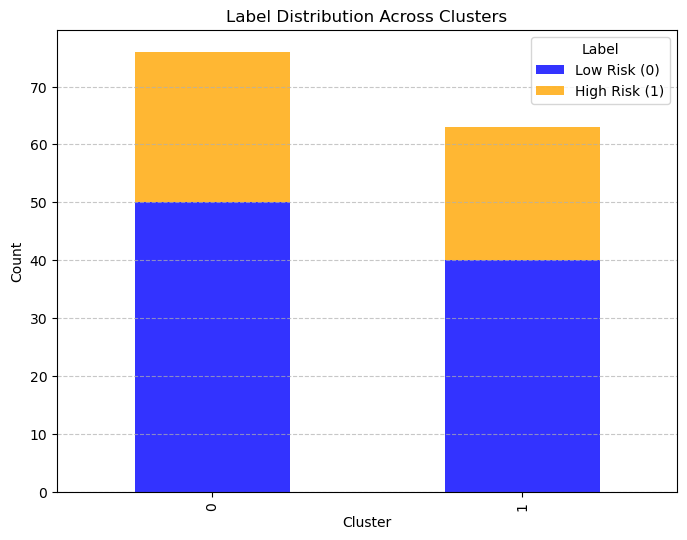

In [40]:
# Group by Cluster and Label, then count occurrences
label_distribution = kmeans_stats_df.groupby(['Cluster', 'Label']).size().unstack(fill_value=0)

# Plot stacked bar chart
label_distribution.plot(kind='bar', stacked=True, figsize=(8, 6), alpha=0.8, color=['blue', 'orange'])
plt.title('Label Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Label', labels=['Low Risk (0)', 'High Risk (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [41]:
# Function to plot the distribution of a column across clusters
def plot_distribution(df, column, title):
    plt.figure(figsize=(8, 6))
    for cluster_id in df['Cluster'].unique():
        subset = df[df['Cluster'] == cluster_id]
        values = subset[column].value_counts()
        plt.bar(values.index, values, alpha=0.7, label=f'Cluster {cluster_id}')
    
    plt.title(f'{title} Distribution Across Clusters')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(title='Cluster')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


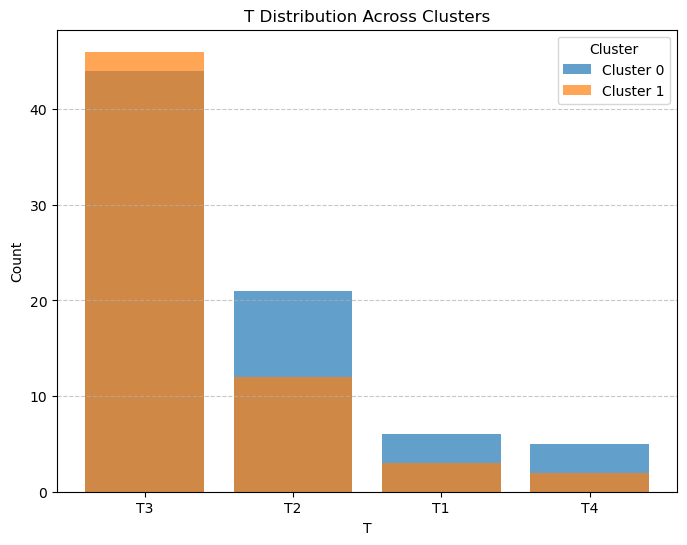

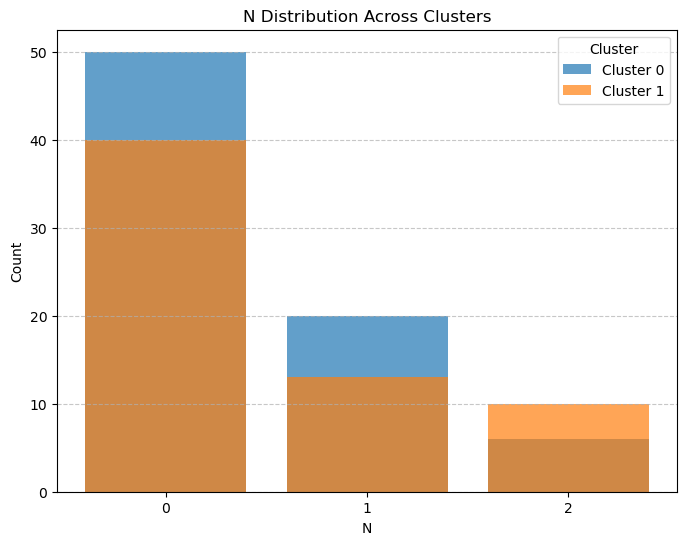

In [42]:
# Plot the distribution of T values across clusters
plot_distribution(kmeans_stats_df, 'T', 'T')

# Plot the distribution of N values across clusters
plot_distribution(kmeans_stats_df, 'N', 'N')

In [43]:
print(kmeans_stats_df.groupby('Cluster')['T'].value_counts())
print(kmeans_stats_df.groupby('Cluster')['N'].value_counts())
print(kmeans_stats_df.groupby('Cluster')['Label'].value_counts())
print(kmeans_stats_df.groupby('Cluster')['M'].value_counts())

Cluster  T 
0        T3    44
         T2    21
         T1     6
         T4     5
1        T3    46
         T2    12
         T1     3
         T4     2
Name: count, dtype: int64
Cluster  N
0        0    50
         1    20
         2     6
1        0    40
         1    13
         2    10
Name: count, dtype: int64
Cluster  Label
0        0        50
         1        26
1        0        40
         1        23
Name: count, dtype: int64
Cluster  M 
0        M0    35
         Mx    22
         M1     5
1        M0    24
         Mx    20
         M1     5
Name: count, dtype: int64
